In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import azureml.core
from azureml.core import Workspace , Dataset
from multiprocessing import cpu_count

# Tweets Sentiment analysis
# Loading and preprocessing data
- apply stemmer/ lemmatizer
- select target and text columns
- remove URL
- remove punctuation
- remove rows with Nan
- remove stopwords
- tokenize

In [121]:
dataset= pd.read_csv("tw.csv", names=["Col1","Col2","Col3","Col4","Col5","Col6"], encoding='ISO-8859-1') 

from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
import string
import re

##############################################################
##STEMMER##
ps = PorterStemmer()
dataset['Col6']=dataset['Col6'].apply(lambda x: " ".join(ps.stem(i) for i in tknzr.tokenize(x) ))

###############################################################

################################################################
#LEMMATIZER##
#lemmatizer = WordNetLemmatizer()
#dataset['Col6']=dataset['Col6'].apply(lambda x: " ".join(lemmatizer.lemmatize(i) for i in tknzr.tokenize(x) ))
#################################################################
dataset['Col6']=dataset['Col6'].apply(lambda x: re.sub("@S+|www?:\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+",' ',x))
dataset= dataset.dropna(axis=0, how="any")
dataset['Col6']=dataset['Col6'].str.replace('\d+', '').apply(lambda x:str(x).translate(str.maketrans('', '', string.punctuation)).lower().rstrip())
dataset['Col6'].head()

0      awww that a bummer you shoulda got david car...
1    is upset that he can t updat hi facebook by te...
2    i dive mani time for the ball manag to save  t...
3         my whole bodi feel itchi and like it on fire
4    no it not behav at all i m mad whi am i here b...
Name: Col6, dtype: object

In [122]:
dataset= dataset[["Col1","Col6"]]
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 
dataset.head()

,Col1,Col6
0,0,awww that a bummer you shoulda got david car...
1,0,is upset that he can t updat hi facebook by te...
2,0,i dive mani time for the ball manag to save t...
3,0,my whole bodi feel itchi and like it on fire
4,0,no it not behav at all i m mad whi am i here b...


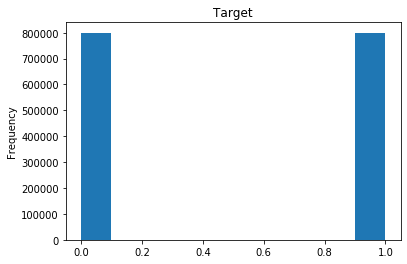

In [187]:
dataset["Col1"].plot(kind="hist", title="Target")

In [123]:
dataset['Col6'] = dataset['Col6'].apply(lambda x: [w for w in word_tokenize(x) if not w in stop_words])
dataset['Col6'].head()

0    [awww, bummer, shoulda, got, david, carr, thir...
1    [upset, updat, hi, facebook, text, might, cri,...
2    [dive, mani, time, ball, manag, save, rest, go...
3               [whole, bodi, feel, itchi, like, fire]
4                       [behav, mad, whi, becaus, see]
Name: Col6, dtype: object

# Simple model

Word vectors has been averaged into 1D corpus representation
- apply fasttext and word2vec algorithms
- build vocabulary


In [ ]:
ds=dataset
from gensim.models import Word2Vec, FastText
############FASTTEXT#############
model = FastText(word_tokens, min_count=1, size=8,workers=cpu_count())
#################################

##############Word2Vec###########
#model = Word2Vec(word_tokens, min_count=1, size=8,workers=cpu_count())
################################
word_tokens=ds['Col6']
words = list(model.wv.vocab)
print(words)


- average vectors
- replace words with average of vectors

In [125]:
dic={}
ww=list(model.wv.vocab)
for i in ww:
    dic.update({i:model.wv[i].mean()})
len(dic)


214918

In [126]:
final=[]
for i in ds["Col6"]:
    arr=[]
    for u in i:
        if u in dic.keys():
            arr.append(dic[u])
        else:
            print(u)
    final.append(arr)

- keep 20 words per tweet, to have equal matrix of documents
- check if all the documents have the same length

In [127]:
#keeping 20 words per tweet

for i in final:
    if len(i)<21:
        for b in range(len(i),20):
            i.append(0)
    elif len(i)>20:
        b=len(i)
        while b>20:
            i.pop(b-1)
            b=b-1

In [128]:
#check nr tweets
max=0
min=90
for i in final:
    if len(i)>max:
        max=len(i)
    if len(i)<min:
        min=len(i)
print(min)
print(max)

20
20


In [129]:
X= pd.DataFrame(final)
X.shape

(1600000, 20)

In [130]:
ds['Col1']= ds['Col1'].replace(4,1)
Y=ds['Col1']
Y.shape


(1600000,)

- define DNN model 
- split dataset into test and train sets
- fit and run model

In [133]:
%time
# Import `Sequential` from `keras.models`
from keras.models import Sequential
from sklearn.model_selection import train_test_split
# Import `Dense` from `keras.layers`
from keras.layers import Dense
from keras.layers import SimpleRNN

# Initialize the constructor
model = Sequential()
# Add an input layer 
model.add(Dense(20, activation='relu', input_shape=(20,)))
model.add(Dense(16, activation='relu'))

model.add(Dense(12, activation='relu'))
# Add one hidden layer 
model.add(Dense(8, activation='relu'))
# Add an output layer 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model.fit(X_train, y_train,epochs= 10, batch_size=5, verbose=1, validation_split=0.2 )


Wall time: 0 ns
Train on 1024000 samples, validate on 256000 samples
Epoch 1/10
1024000/1024000 [==============================] - 241s 236us/step - loss: 0.6742 - accuracy: 0.5680 - val_loss: 0.6707 - val_accuracy: 0.5746
Epoch 2/10
1024000/1024000 [==============================] - 248s 242us/step - loss: 0.6707 - accuracy: 0.5743 - val_loss: 0.6698 - val_accuracy: 0.5749
Epoch 3/10
1024000/1024000 [==============================] - 249s 243us/step - loss: 0.6695 - accuracy: 0.5768 - val_loss: 0.6687 - val_accuracy: 0.5758
Epoch 4/10
1024000/1024000 [==============================] - 244s 238us/step - loss: 0.6690 - accuracy: 0.5766 - val_loss: 0.6692 - val_accuracy: 0.5750
Epoch 5/10
1024000/1024000 [==============================] - 236s 231us/step - loss: 0.6685 - accuracy: 0.5781 - val_loss: 0.6679 - val_accuracy: 0.5789
Epoch 6/10
1024000/1024000 [==============================] - 240s 235us/step - loss: 0.6686 - accuracy: 0.5790 - val_loss: 0.6675 - val_accuracy: 0.5807
Epoch 7

In [134]:
acc= model.evaluate(X_test,y_test)
print(acc)

320000/320000 [==============================] - 5s 15us/step
[0.6679766739666462, 0.5808968544006348]


In [135]:
y_scores = model.predict_classes(X_test)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_scores)


0.5813331548131104

# Summary Basic Model

<table><th>Model</th><th>Word ending</th><th>Vectorization</th><th>Accuracy</th><th>Loss</th><th>AUC</th><th>Max Time</th>
    <tr>
        <td>Input20/Dense16/Dense12/Dense8/Output1</td><td>Lemmatization</td><td>Word2vec<td>0.58</td><td>0.67</td><td>0.58</td><td>193</td>
        </tr><tr>
    <td>Input20/Dense16/Dense12/Dense8/Output1</td><td>Lemmatization</td><td>FastText<td>0.55</td><td>0.68</td><td>0.55</td><td>244</td></tr><tr>
    <td>Input20/Dense16/Dense12/Dense8/Output1</td><td>Stemming</td><td>FastText<td>0.58</td><td>0.67</td><td>0.58</td><td>249</td>
     </tr><tr>
    <td>Input20/Dense16/Dense12/Dense8/Output1</td><td>Stemming</td><td>Word2vec<td>0.58</td><td>0.67</td><td>0.58</td><td>190</td>
     </tr></table>

# Multiple dimentions model
Keeping 100 word vectors and loading them into Embeding layer of keras model
- preprocessing documents
- keep target and text column
- apply lemmitizer or stemmer
- remove stopwords
- remove URI
- remove punctuation

In [165]:
dataset= pd.read_csv("tw.csv", names=["Col1","Col2","Col3","Col4","Col5","Col6"], encoding='ISO-8859-1') 
#data preprocessing- done
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
import string
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from multiprocessing import cpu_count
stop_words = set(stopwords.words('english')) 

############ LEMMITIZER ###############
#lemmatizer = WordNetLemmatizer()
#dataset['Col6']=dataset['Col6'].apply(lambda x: " ".join(lemmatizer.lemmatize(i) for i in tknzr.tokenize(x) if not i in stop_words ))
#######################################

########### STEMMER ##################
ps = PorterStemmer()
dataset['Col6']=dataset['Col6'].apply(lambda x: " ".join(ps.stem(i) for i in tknzr.tokenize(x) if not i in stop_words ))
######################################

dataset['Col6']=dataset['Col6'].apply(lambda x: re.sub("@S+|www?:\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+",' ',x))
dataset['Col1']= dataset['Col1'].replace(4,1)
dataset['Col6']=dataset['Col6'].str.replace('\d+', '').apply(lambda x:str(x).translate(str.maketrans('', '', string.punctuation)).lower().rstrip())
dataset= dataset[["Col1","Col6"]]
dataset= dataset.dropna(axis=0,how="any")
ds= dataset

- tokenize documents
- apply end of word processing algorithm word2vec /fasttex
- create vocabulary
- create 100 dimentional matrix that represents the distionary

In [ ]:
from multiprocessing import cpu_count
from gensim.models import FastText, Word2Vec

tokenized= ds
word_tokens= tokenized['Col6'].apply(lambda x: [w for w in word_tokenize(x)])
nrDimentsions=100

######## Word2Text ####################
#model = Word2Vec(word_tokens, min_count=1, size=nrDimentsions,workers=cpu_count())
#######################################

######## FastText ######################
model = FastText(word_tokens, min_count=1, size=nrDimentsions,workers=cpu_count())
########################################

words = list(model.wv.vocab)
print(words)

# save the vectors in a new matrix
embedding_matrix = np.zeros((len(model.wv.vocab) + 1, nrDimentsions))
for i, vec in enumerate(model.wv.vectors):
    embedding_matrix[i] = vec

In [167]:
model.train(word_tokens,total_examples=len(word_tokens),epochs=10)

WARNING - Effective 'alpha' higher than previous training cycles


- define DNN model with multidimentional input
- prepare tokens for model loading
- split data into train and test
- save tokenizer to file
- fit model

In [168]:
# more imports
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# how many features should the tokenizer extract
features = embedding_matrix.shape[0]
tokenizer = Tokenizer(num_words = features)
# fit the tokenizer on our text
tokenizer.fit_on_texts(ds['Col6'])

# get all words that the tokenizer knows
word_index = tokenizer.word_index

# put the tokens in a matrix
X = tokenizer.texts_to_sequences(ds['Col6'])
X = pad_sequences(X)

# prepare the labels
y = pd.get_dummies(ds['Col1'])

# split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, ds['Col1'], test_size=0.1, random_state=42)

- save tokenizer
- fit model
- calculate mertics
- save model

In [169]:
import pickle

# saving tokenizer to file
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [170]:
X.shape

(1600000, 42)

In [171]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, Activation,Conv1D,MaxPooling1D

# init model
mod = Sequential()
# emmbed word vectors
mod.add(Embedding(len(model.wv.vocab)+1,nrDimentsions,input_length=X.shape[1],weights=[embedding_matrix],trainable=False))
mod.add(Dropout(0.25))

#mod.add(MaxPooling1D(pool_size=4))
mod.add(LSTM(200))

mod.add(Dense(1))
mod.add(Activation('sigmoid'))


mod.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [172]:
%time
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
mod.fit(X_train,y_train,epochs= 2, batch_size=5, verbose=1, validation_split=0.2, callbacks= [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)])

Wall time: 2.18 ms
Train on 1152000 samples, validate on 288000 samples
Epoch 1/2
1152000/1152000 [==============================] - 5756s 5ms/step - loss: 0.5379 - accuracy: 0.7239 - val_loss: 0.5115 - val_accuracy: 0.7447
Epoch 2/2


C:\Users\lesh3\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1152000/1152000 [==============================] - 6530s 6ms/step - loss: 0.5260 - accuracy: 0.7334 - val_loss: 0.5062 - val_accuracy: 0.7489


In [173]:
acc= mod.evaluate(X_test,y_test)
print(acc)

y_scores = mod.predict_classes(X_test)


160000/160000 [==============================] - 101s 633us/step
[0.5059733984947204, 0.7489562630653381]


In [34]:
# serialize model to JSON
model_json = mod.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
mod.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [174]:
roc_auc_score(y_test, y_scores)

0.7488592621377752

# Summary Multiple Dimentions Input Model

<table><th>Model</th><th>Word ending</th><th>Vectorization</th><th>Accuracy</th><th>Loss</th><th>AUC</th><th>Max Time</th>
    <tr>
        <td>Embedding/Dropout0.25/LSMT200/Output1</td><td>Lemmatization</td><td>Word2vec<td>0.7594</td><td>0.49</td><td>0.7595</td><td>5203</td>
        </tr><tr>
    <td>Embedding/Dropout0.25/LSMT200/Output1</td><td>Lemmatization</td><td>FastText<td>0.749</td><td>0.506</td><td>0.7489</td><td>6530</td></tr><tr>
    <td>Embedding/Dropout0.25/LSMT200/Output1</td><td>Stemming</td><td>FastText<td>0.748</td><td>0.508</td><td>0.748</td><td>5629</td>
     </tr><tr>
    <td>Embedding/Dropout0.25/LSMT200/Output1</td><td>Stemming</td><td>Word2vec<td>0.762</td><td>0.48</td><td>0.763</td><td>5408</td>
     </tr></table>

# Commercial API Test

In [176]:
import http.client, urllib.request, urllib.parse, urllib.error, base64, json
datas= pd.read_csv("tw.csv", names=["Col1","Col2","Col3","Col4","Col5","Col6"], encoding='ISO-8859-1')
counter=0
for i in datas['Col6'].iteritems():
    counter=counter+1
    if counter==10:
        break
    else:
        headers = {
    # Request headers
    'Content-Type': 'application/json',
    'Ocp-Apim-Subscription-Key': 'key',
}

        params = urllib.parse.urlencode({
    # Request parameters
    'showStats': '{true}',
    'model-version': '{2}',
})

        try:
            conn = http.client.HTTPSConnection('westcentralus.api.cognitive.microsoft.com')
            conn.request("POST", "/text/analytics/v2.0/sentiment?%s" % params, json.dumps(
  {"documents": [
    {
      "language": "en",
      "id": "1",
      "text": str(i)
    }]}), headers)
            response = conn.getresponse()
            data = response.read()
            print(i)
            print(data)
            conn.close()
        except Exception as e:
            print("[Errno {0}] {1}".format(e.errno, e.strerror))
    

    



(0, "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D")
b'{"documents":[{"id":"1","score":0.87795019149780273}],"errors":[]}'
(1, "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!")
b'{"documents":[{"id":"1","score":0.11837613582611084}],"errors":[]}'
(2, '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds')
b'{"documents":[{"id":"1","score":0.8160826563835144}],"errors":[]}'
(3, 'my whole body feels itchy and like its on fire ')
b'{"documents":[{"id":"1","score":0.056455731391906738}],"errors":[]}'
(4, "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ")
b'{"documents":[{"id":"1","score":0.026735126972198486}],"errors":[]}'
(5, '@Kwesidei not the whole crew ')
b'{"documents":[{"id":"1","score":0.720441460609436}],"errors":[]}'
(6, 'Need a hug ')
b'{"document

# Customized Model Deployed Test

In [189]:
import requests
import json

scoring_uri = 'http://b713b98a-5ead-4c2b-ba9a-9ff4682b1712.eastus.azurecontainer.io/score'
headers = {'Content-Type':'application/json'}
counter=0
for i in datas['Col6'].iteritems():
    counter=counter+1
    if counter==10:
        break
    else:
        print(i[1])
        test_data = json.dumps({'text': i[1]})

        response = requests.post(scoring_uri, data=test_data, headers=headers)
       
        print(response.elapsed)
        print(response.json())
        print("*******************************************************")

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
0:00:00.656637
Positive
*******************************************************
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
0:00:00.308153
Negative
*******************************************************
@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
0:00:00.263334
Negative
*******************************************************
my whole body feels itchy and like its on fire 
0:00:00.251848
Negative
*******************************************************
@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
0:00:00.287267
Negative
*******************************************************
@Kwesidei not the whole crew 
0:00:00.282035
Positive
*******************************************************
Need a hug 
